# Univariate multi-step timeseries forecasting with Keras

> A example of using an LSTM network to forecast an univariate multi-step timeseries with Keras.

- toc: true 
- badges: true
- comments: true
- categories: [lstm, keras, python, machine learning, timeseries]
- image: images/copied_from_nb/images/2021-06-04-univariate-multi-step-timeseries-forecasting-with-keras-main.jpg

# About

Another attempt to use an `LSTM` based neural network (RNN) to forecast univariate multi-step `timeseries` data.

![](./images/2021-06-04-univariate-multi-step-timeseries-forecasting-with-keras-main.jpg "Photo by Aron Visuals")

## The required libraries

Import the `must-have` libraries:

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from IPython import display as ids

Import the elements required from the `scikit-learn` library:

In [2]:
import sklearn as sk
import sklearn.preprocessing as skp
import sklearn.model_selection as skms
import sklearn.pipeline as skpl
import sklearn.decomposition as skd
import sklearn.linear_model as sklm
import sklearn.dummy as sky
import sklearn.metrics as skme

Enables defining partial functions:

In [3]:
from functools import partial

Import the `keras` elements from the `tensorflow` library:

In [4]:
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import backend as kb
from tensorflow.keras import callbacks as kc
from tensorflow.keras import models as km
from tensorflow.keras import layers as kl
from tensorflow.keras import regularizers as kr
from tensorflow.keras import optimizers as ko
from tensorflow.keras import utils as ku

Import `matplotlib` and set the default magic:

In [5]:
import matplotlib as mat
from matplotlib import pyplot as plt
import pylab as pyl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Import the `mlviz` library used to plot `time-series` visualizations:

In [6]:
from mlviz.timeseries import visualizationhelpers as mwvh
from mlviz.utilities import graphichelpers as mwgh

## The project parameters

Reset the predefined `matplotlib` style:

In [7]:
mwgh.GraphicsStatics.initialize_matplotlib_styles()

Here is the **color palette** we'll use for the project:

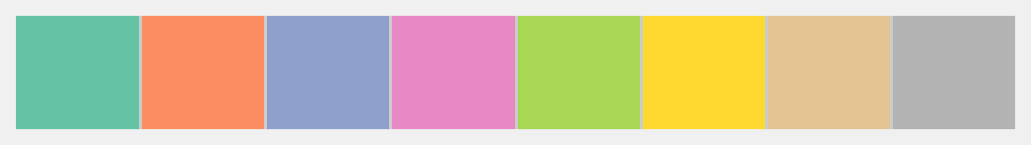

In [8]:
sns.palplot(mwgh.GraphicsStatics.g_palette)

Let's capture all the usefull project's **parameters** in a dictionary:

In [9]:
params = {}

params['project_date'] = '2021-05-31'
params['project_name'] = 'LSTM+01'
params['experiment_timestamp'] = str(int(1000 * dt.datetime.timestamp(dt.datetime.utcnow())))

params['experiment_name'] = '{0}-{1}-{2}'.format(
    params['project_date'], 
    params['experiment_timestamp'],
    params['project_name'])

params['data_frequency'] = 'W-SAT'
params['features'] = ['y']

params['input_size'] = 52          # N weeks of data to input into the network
params['output_size'] = 13         # N weeks of data to output from the network
params['testing_size'] = 52        # N weeks of data to keep for testing the model
params['lag_size'] = None

params['hyperband_iterations'] = 3
params['max_epochs'] = 250
params['patience'] = int(params['max_epochs'] / 10)
params['batch_size'] = 16

## The timeseries data

The input data is available in a `csv` file named `timeseries-data.csv` located in the `data` folder. It has got 2 columns `date` containing the date of event and `value` holding the value of the source. We'll rename these 2 columns as `ds` and `y` for convenience. Let's load the `csv` file using the `pandas` library and have a look at the data.

In [10]:
df = pd.read_csv(
    filepath_or_buffer='../assets/data/timeseries-data.csv',
    sep=';')

df.rename(
    columns = {
        'date': 'index',
        'value': 'y'
    }, 
    inplace=True)

df['index'] = pd.to_datetime(
    arg=df['index'], 
    dayfirst=True)

df.sort_values(
    by='index', 
    ascending=True,
    inplace=True)

df.set_index(
    keys='index', 
    inplace=True)

df = df.asfreq(
    freq=params['data_frequency'])

df['ds'] = df.index

print('df.shape = {0}'.format(df.shape))

df.tail(5)

df.shape = (625, 2)


,y,ds
index,,
2019-09-28,5547,2019-09-28
2019-10-05,6459,2019-10-05
2019-10-12,5838,2019-10-12
2019-10-19,5894,2019-10-19
2019-10-26,7925,2019-10-26


### Prepare data for the network

It's easy to calculate the **width** of a sample:

In [11]:
def get_maximum_lag_size(lag_data):
    steps_lag = 0
    
    if lag_data is not None and len(lag_data) > 0:
        steps_lag = max(lag_data)

    return steps_lag

In [12]:
sample_width = get_maximum_lag_size(params['lag_size']) + params['input_size'] + params['output_size']
print('sample_width: {0}'.format(sample_width))

sample_width: 65


To avoid any overlap between the `training` and the `testing` data set, we'll first split the dataframes, keeping `params['testing_size']` samples for testing our model. We need to make sure that no data point used for training is also used for testing our model.

In [13]:
threshold_date = pd.to_datetime(df.index[df.shape[0] - (sample_width + params['testing_size'])])
print('Cutoff date for training/testing split is {0}'.format(threshold_date.strftime('%d/%m/%Y')))

Cutoff date for training/testing split is 05/08/2017


Let's cut the dataframe at the right date:

In [14]:
test_mask = (df['ds'] > threshold_date)
df_train = df[~test_mask]
df_test = df[test_mask]
print('df_train.shape = {0}'.format(df_train.shape))
print('df_test.shape = {0}'.format(df_test.shape))

df_train.shape = (509, 2)
df_test.shape = (116, 2)


The `prepare_data` funtion will take care of doing exactly this:

In [15]:
def prepare_data(data, lag_data, cols_in, steps_in, cols_out, steps_out, scaler_in=None, scaler_out=None):
    
    df = data.copy()
    cols_in_original = [col for col in cols_in]
    cols_in_processed = [col for col in cols_in]
    
    steps_lag = get_maximum_lag_size(lag_data)
    
    if steps_lag > 0:
        for col in cols_in_original:
            for i, lag in enumerate(lag_data):
                lag_col = '{0}_{1}'.format(col, lag)
                df[lag_col] = df[col].shift(lag)
                cols_in_processed.append(lag_col)
        
    samples = df.shape[0] - (steps_in + steps_out + steps_lag) + 1
    
    if samples < 1:
        raise ValueError('not enough data to produce 1 sample.')
    
    index = list(df.index)
    cols_in_indices = {name: i for i, name in enumerate(cols_in_processed)}
    cols_out_indices = {name: i for i, name in enumerate(cols_out)}
    
    df.reset_index(inplace=True)
    
    
    X_input_scaled = None
    
    if scaler_in is None:
        scaler_in = skpl.Pipeline([
            ('std', skp.StandardScaler()),
            ('minmax', skp.MinMaxScaler(feature_range=(-1, 1)))])

        X_input_scaled = scaler_in.fit_transform(df[cols_in_processed].values)
    else:
        X_input_scaled = scaler_in.transform(df[cols_in_processed].values)
    
    
    y_output_scaled = None
    
    if scaler_out is None:
        scaler_out = skpl.Pipeline([
            ('std', skp.StandardScaler()),
            ('minmax', skp.MinMaxScaler(feature_range=(-1, 1)))])

        y_output_scaled = scaler_out.fit_transform(df[cols_out].values)
    else:
        y_output_scaled = scaler_out.transform(df[cols_out].values)
        
        
    X = []
    y = []
    
    for sample in range(samples):
        for step_in in range(steps_in):
            for col_in in range(len(cols_in_processed)):
                X.append(X_input_scaled[sample+steps_lag+step_in, col_in])
        for step_out in range(steps_out):
            for col_out in range(len(cols_out)):
                y.append(y_output_scaled[sample+steps_lag+steps_in+step_out, col_out])
    
    X = np.array(X).reshape(samples, steps_in, len(cols_in_processed))
    y = np.array(y).reshape(samples, steps_out, len(cols_out))
    
    return X, y, index, scaler_in, scaler_out, cols_in_indices, cols_out_indices

Every intput feature (passed via the function parameter `cols_in`) is going to be rescalled using a `scikit-learn` pipeline containing first a `StandardScaler` and then a `MinMaxScaler` in order to end up with a feature range of `[-1, +1]` required by neural networks.

In [16]:
X_train, y_train, index_train, scaler_in, scaler_out, cols_in_indices_train, cols_out_indices_train = prepare_data(
    data=df_train,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'])

print('X_train.shape: {0}'.format(X_train.shape))
print('y_train.shape: {0}'.format(y_train.shape))

X_train.shape: (445, 52, 1)
y_train.shape: (445, 13, 1)


To prepare the `testing` data, we need to reuse both **input** (variable `scaler_in`) and **output** (variable `scaler_out`) pipelines in order to keep data scaled in the same way.

In [17]:
X_test, y_test, index_test, _, _, cols_in_indices_test, cols_out_indices_test = prepare_data(
    data=df_test,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'],
    scaler_in=scaler_in, 
    scaler_out=scaler_out)

print('X_test.shape: {0}'.format(X_test.shape))
print('y_test.shape: {0}'.format(y_test.shape))

X_test.shape: (52, 52, 1)
y_test.shape: (52, 13, 1)


Let's compute the entire dataset and keep the output data for visualization:

In [18]:
X, y, index, _, _, cols_in_indices, cols_out_indices = prepare_data(
    data=df,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'],
    scaler_in=scaler_in, 
    scaler_out=scaler_out)

print('X.shape: {0}'.format(X.shape))
print('y.shape: {0}'.format(y.shape))

X.shape: (561, 52, 1)
y.shape: (561, 13, 1)


### Data visualization

Let's have a look at the visual representation of the timeseries data:

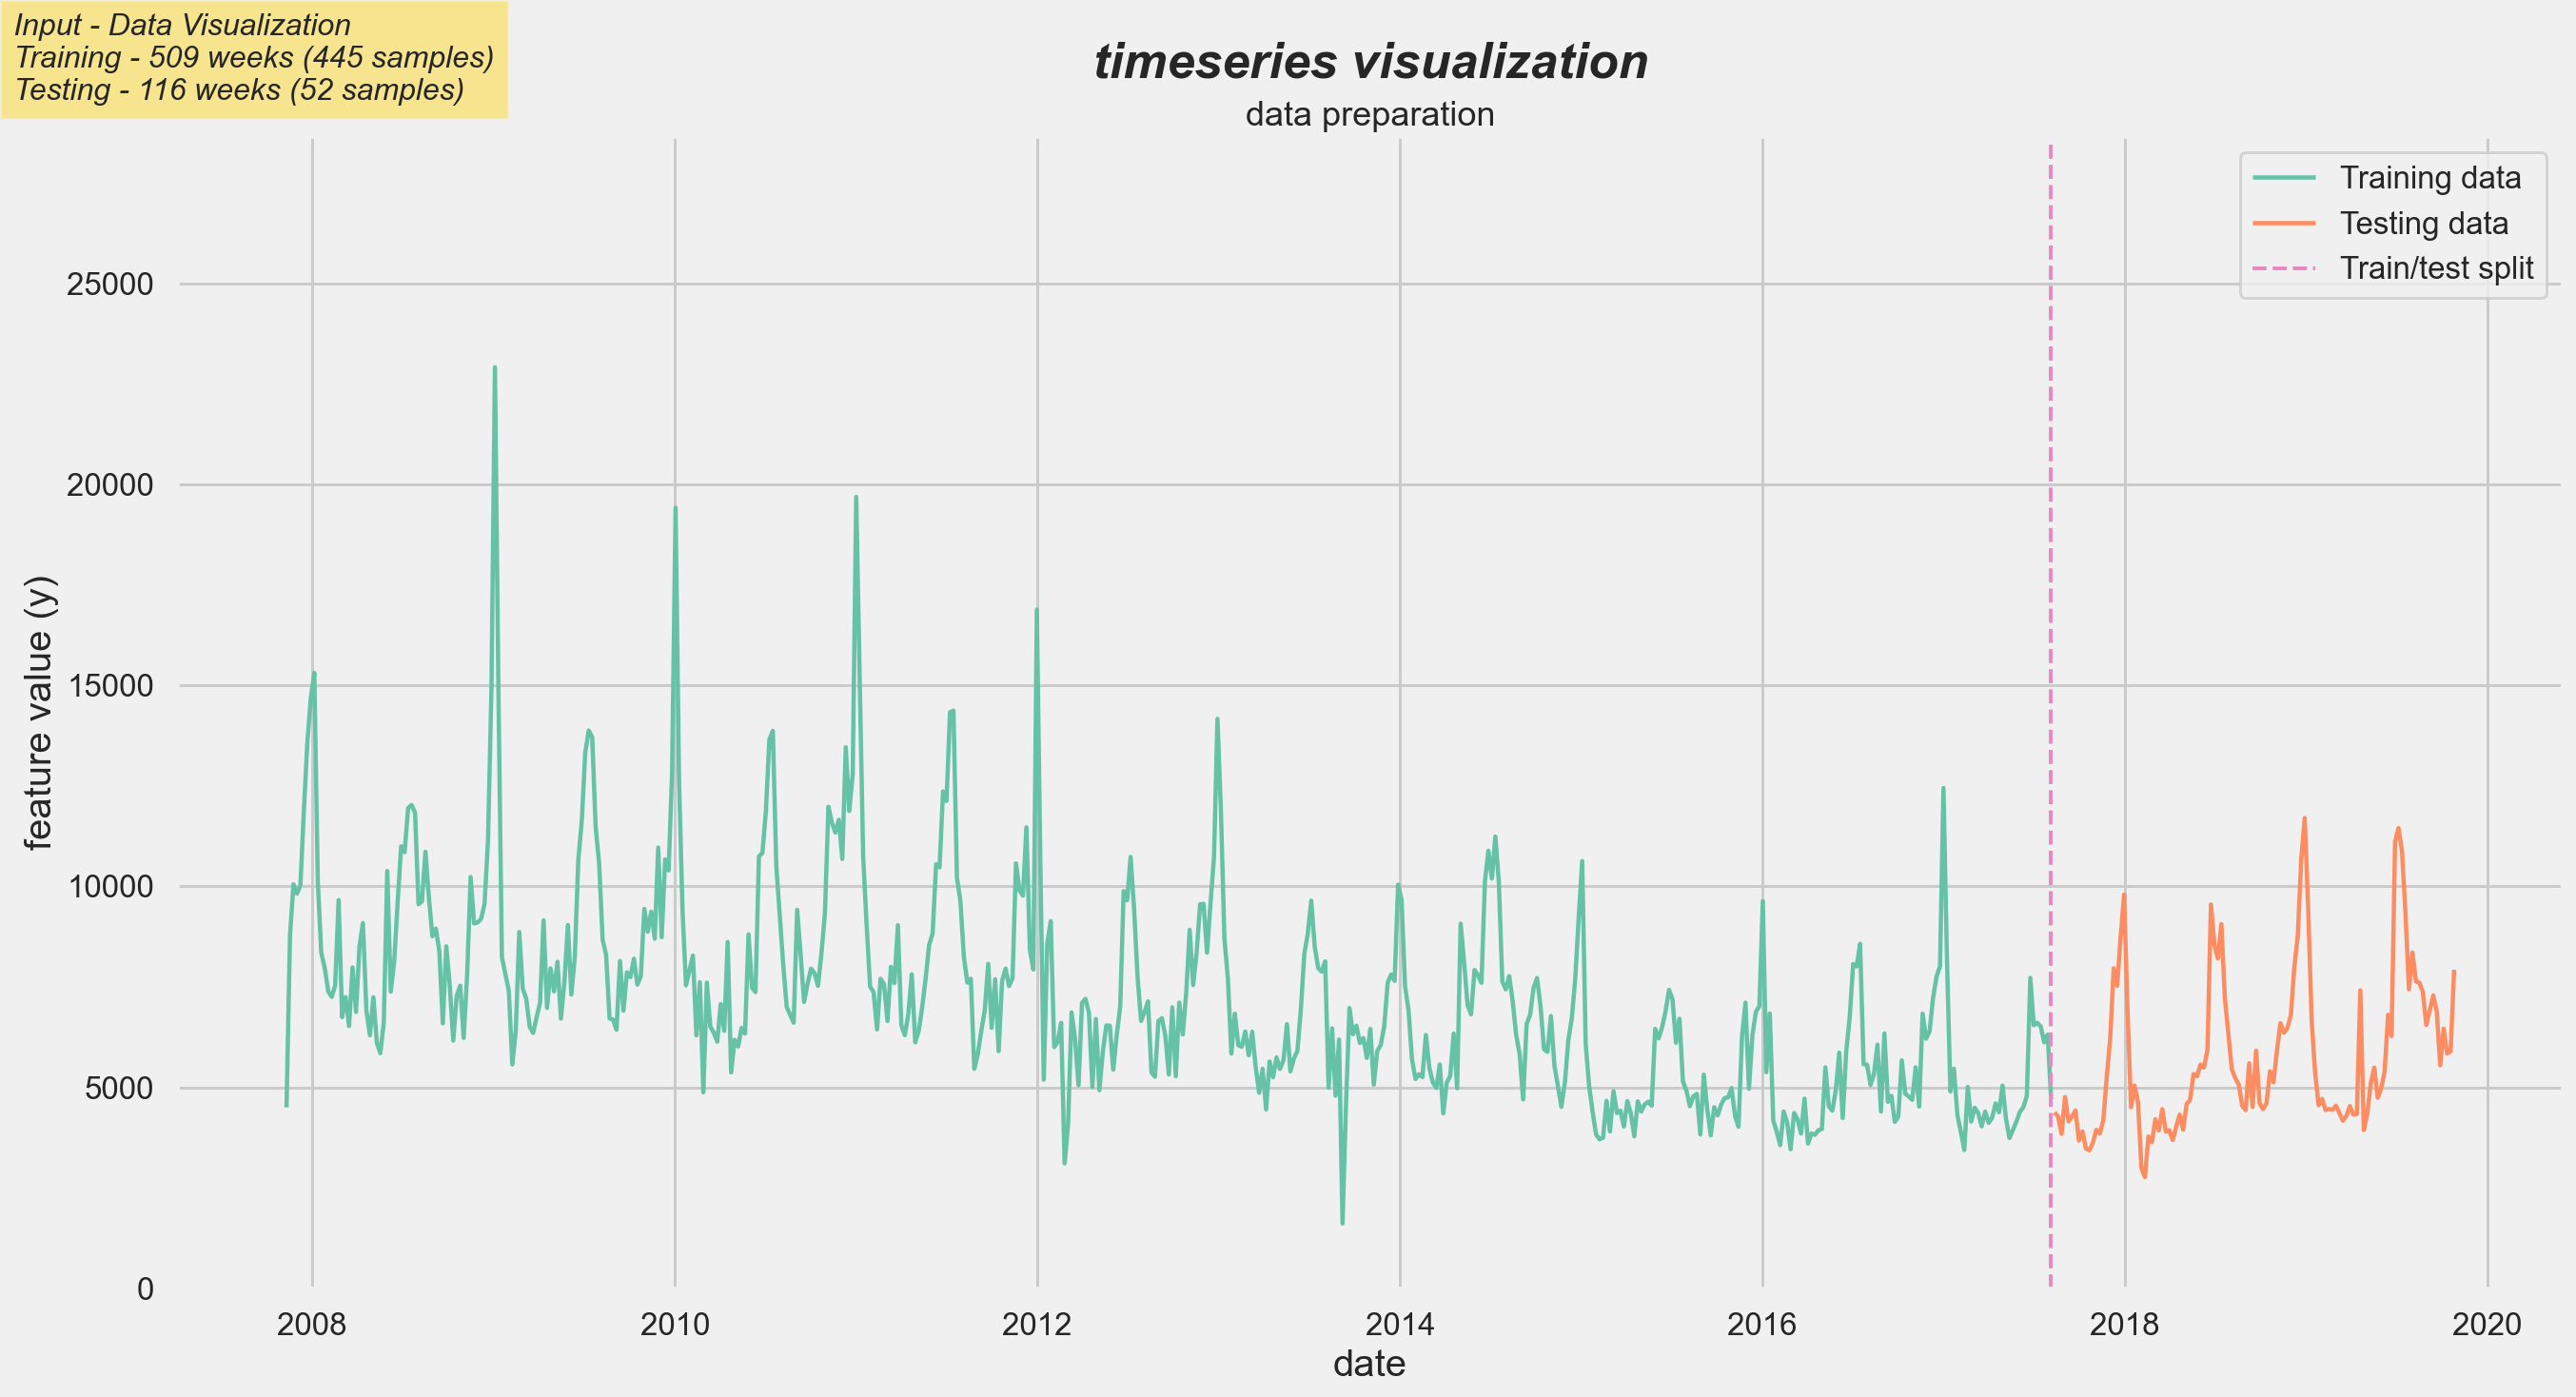

In [19]:
mwvh.plot_time_series(
    title='timeseries visualization',
    subtitle='data preparation',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    training=df_train,
    testing=df_test,
    ylabel='feature value (y)',
    split=threshold_date)

## Build the model

### Model definition

We'll use `RMSE` as our loss function to optimize (it is required to be defined as a function that can be compiled by `TensorFlow`):

In [20]:
def rmse_tf(y_true, y_pred):
    return tf.cast(
        tf.sqrt(
            tf.reduce_mean(
                tf.square(
                    tf.subtract(
                        y_pred,
                        y_true)))),
        dtype=tf.float32)

First, we define a `create_model` function:

In [21]:
def create_model(loss_fn, steps_in, steps_out, n_features):

    # define model
    model = km.Sequential()
    model.add(kl.LSTM(steps_in, activation='tanh', return_sequences=True, input_shape=(steps_in, n_features)))
    model.add(kl.LSTM(2*steps_in, activation='tanh', return_sequences=True, dropout=.5))
    model.add(kl.LSTM(4*steps_in, activation='tanh'))
    model.add(kl.Dense(steps_out, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_fn)

    return model

In [22]:
model = create_model(
    loss_fn=rmse_tf, 
    steps_in=params['input_size'], 
    steps_out=params['output_size'], 
    n_features=len(params['features']))

Let's **fit** this model using the data we loaded earlier:

In [23]:
print('X_train.shape: {0}'.format(X_train.shape))
print('y_train.shape: {0}'.format(y_train.shape))

X_train.shape: (445, 52, 1)
y_train.shape: (445, 13, 1)


In [24]:
#hide_output
history = model.fit(
    x=X_train, 
    y=y_train, 
    shuffle=True,
    batch_size=params['batch_size'],
    validation_data=(X_test, y_test),
    epochs=params['max_epochs'], 
    callbacks=[ 
        kc.EarlyStopping(
            monitor='val_loss', 
            patience=params['patience'],
            verbose=1,
            mode='min',
            restore_best_weights=True),
        kc.TerminateOnNaN()
    ],
    verbose=2)

Epoch 1/250
28/28 - 5s - loss: 0.2767 - val_loss: 0.2074
Epoch 2/250
28/28 - 17s - loss: 0.2190 - val_loss: 0.2102
Epoch 3/250
28/28 - 5s - loss: 0.2201 - val_loss: 0.2021
Epoch 4/250
28/28 - 1s - loss: 0.2190 - val_loss: 0.2190
Epoch 5/250
28/28 - 1s - loss: 0.2097 - val_loss: 0.1854
Epoch 6/250
28/28 - 1s - loss: 0.1855 - val_loss: 0.1793
Epoch 7/250
28/28 - 1s - loss: 0.1694 - val_loss: 0.2068
Epoch 8/250
28/28 - 1s - loss: 0.1654 - val_loss: 0.1713
Epoch 9/250
28/28 - 1s - loss: 0.1604 - val_loss: 0.1629
Epoch 10/250
28/28 - 1s - loss: 0.1611 - val_loss: 0.1563
Epoch 11/250
28/28 - 1s - loss: 0.1528 - val_loss: 0.1531
Epoch 12/250
28/28 - 1s - loss: 0.1525 - val_loss: 0.1594
Epoch 13/250
28/28 - 1s - loss: 0.1487 - val_loss: 0.1510
Epoch 14/250
28/28 - 1s - loss: 0.1490 - val_loss: 0.1515
Epoch 15/250
28/28 - 1s - loss: 0.1436 - val_loss: 0.1487
Epoch 16/250
28/28 - 1s - loss: 0.1480 - val_loss: 0.1638
Epoch 17/250
28/28 - 1s - loss: 0.1463 - val_loss: 0.1495
Epoch 18/250
28/28 - 1

Here is a **text** version of the model's **architecture** made with **Keras** itself.

In [25]:
model.summary(
    line_length=120)

Model: "sequential"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
lstm (LSTM)                                           (None, 52, 52)                                  11232             
________________________________________________________________________________________________________________________
lstm_1 (LSTM)                                         (None, 52, 104)                                 65312             
________________________________________________________________________________________________________________________
lstm_2 (LSTM)                                         (None, 208)                                     260416            
________________________________________________________________________________________________________________________
dense (Dense

### Model analysis

We can save this default model and use the [Netron](https://github.com/lutzroeder/netron) application to create a visual representation of it.

In [26]:
model.save(
    './.models/{0}.h5'.format(
        params['experiment_name']))

We can see the optimization process on the chart below.

In [27]:
def plot_model_history(history):
    '''
    Summarizes the history for all loss functions,
    throughout the epochs.
    '''
    for fn in list(history.history.keys()):
        plt.plot(history.history[fn])
    
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(list(history.history.keys()), loc='upper right')

    plt.show()

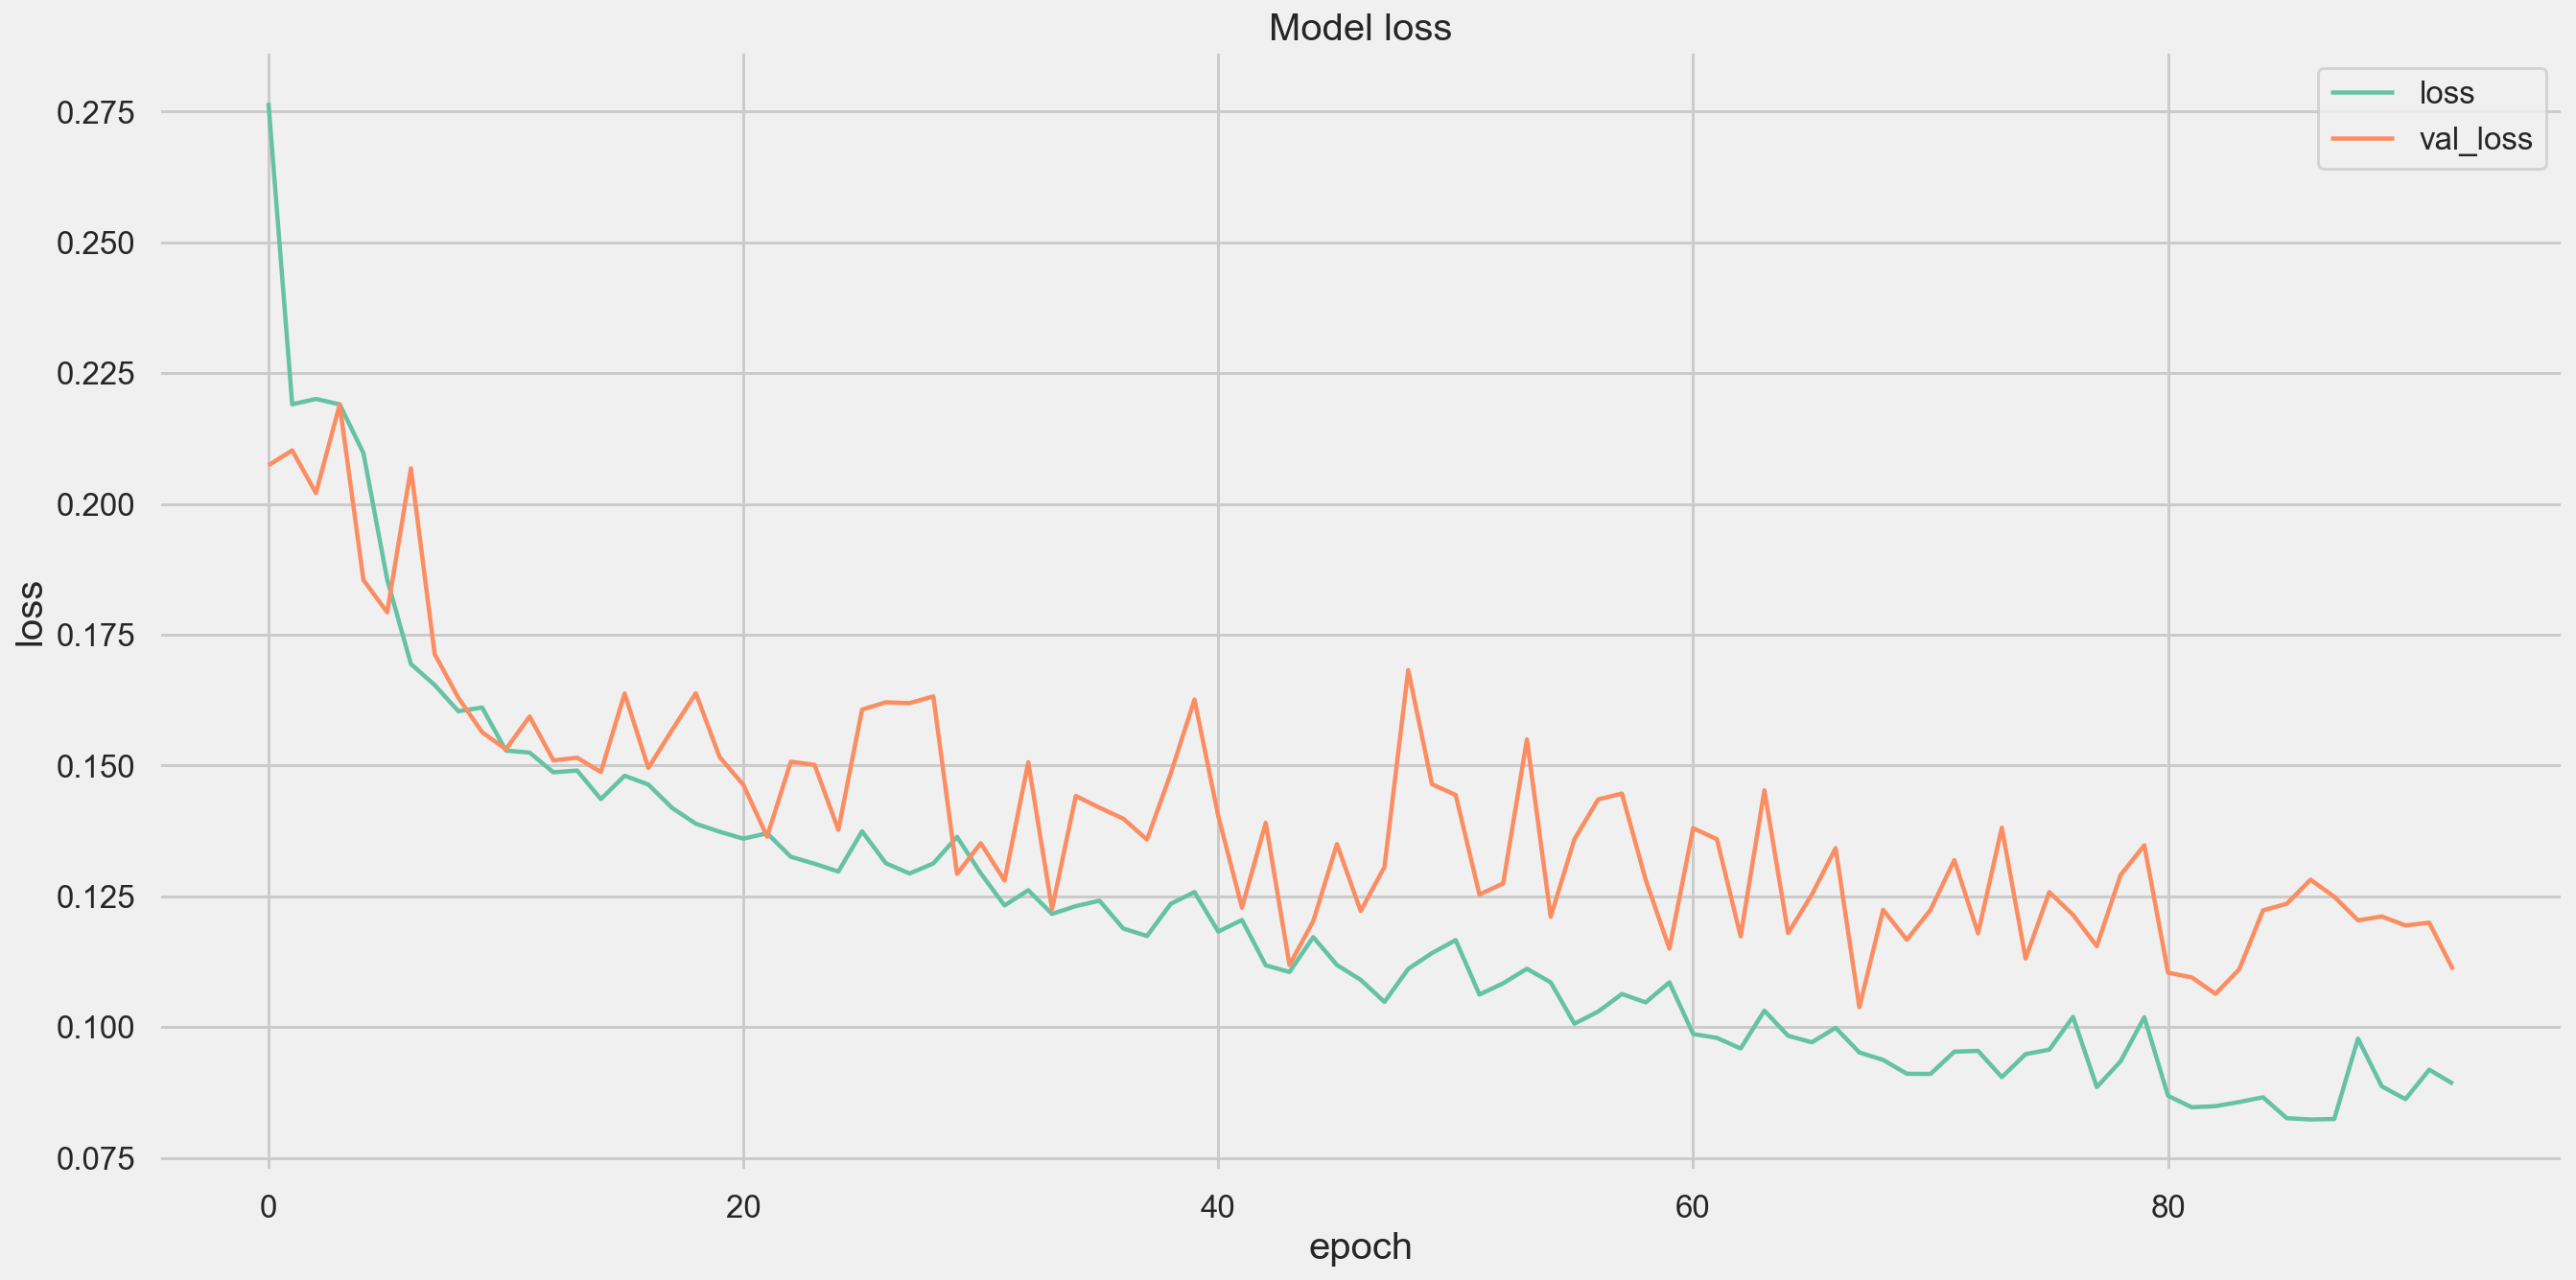

In [28]:
plot_model_history(history=history)

Let's zoom in and focus on the **last n weeks** of data.

In [29]:
def get_n_weeks_window(n_weeks):
    return dt.timedelta(weeks=n_weeks)

We need a functions to compute the various model scores.

In [30]:
def score(loss_fn, y_true, y_pred):
    if loss_fn == 'RMSE':
        return skme.mean_squared_error(
            y_true=y_true,
            y_pred=y_pred,
            squared=False)
    elif loss_fn == 'MSLE':
        return skme.mean_squared_log_error(
            y_true=y_true,
            y_pred=y_pred)
    elif loss_fn == 'MSE':
        return skme.mean_squared_error(
            y_true=y_true,
            y_pred=y_pred,
            squared=True)    
    elif loss_fn == 'R2':
        return skme.r2_score(
            y_true=y_true,
            y_pred=y_pred)    
    elif loss_fn == 'MAE':
        return skme.mean_absolute_error(
            y_true=y_true,
            y_pred=y_pred)
    elif loss_fn == 'MAPE':
        return skme.mean_absolute_percentage_error(
            y_true=y_true,
            y_pred=y_pred)

We can **process** de predicted values returned by the model. The model sequencialy produces `params['output_size']` data points (i.e. the number of weeks of data points predicted). Predictions will enventually overlap, so we can use the `mean` function to get a good candidate of the current value. Similarly, the `min` and the `max` will provide a convenient confidence interval.

In [31]:
def process_predictions(data, X, y, scaler_out, model):
    
    data_pre = data.copy()
    
    scores = []
    predictions = []
    score_functions = ['RMSE', 'MSE', 'R2', 'MAE', 'MAPE']

    lag_data = params['lag_size']
    steps_lag = 0

    if lag_data is not None and len(lag_data) > 0:
        steps_lag = max(lag_data)

    y_preds = model.predict(
        x=X,
        batch_size=params['batch_size'],
        verbose=0)

#     print('y_preds.shape: {0}'.format(y_preds.shape))
    
    y_true_array = []
    y_pred_array = []
    
    for i in range(y.shape[0]):

        t_score = {}

        y_true = scaler_out.inverse_transform(y[i])
        y_pred = scaler_out.inverse_transform(y_preds[i].reshape(-1, 1))

        y_true_array.append(y_true)
        y_pred_array.append(y_pred)
        
        for score_function in score_functions:
            t_score[score_function] = score(
                score_function, 
                y_true,
                y_pred)

        scores.append(t_score)

        prediction = [np.nan] * data_pre.shape[0]

        for j in range(len(y_true)):
            position = steps_lag + i + j + params['input_size']
            prediction[position] = y_pred[j][0]

        predictions.append(
            prediction)

    df_scores = pd.DataFrame.from_records(scores)

    data_pre['yhat_lower'] = pd.DataFrame(predictions).min().values
    data_pre['yhat_upper'] = pd.DataFrame(predictions).max().values
    data_pre['yhat'] = pd.DataFrame(predictions).mean().values
    data_pre['yhat_last'] = predictions[-1]
    data_pre['residual'] = abs(data_pre['yhat'] - data_pre['y'])
    
    pred = {
        'df': data_pre,
        'scores': df_scores,
        'y_true': y_true_array,
        'y_pred': y_pred_array,
        'predictions': predictions
    }

    return pred

In [32]:
pred = process_predictions(
    data=df, 
    X=X, 
    y=y, 
    scaler_out=scaler_out, 
    model=model)

Let's have a look at the model performance:

In [33]:
upper_percentile_score = pred['scores'].iloc[-X_test.shape[0]:]['RMSE'].describe()['75%']
print('75 percentile score: {0:.2f}'.format(upper_percentile_score))

75 percentile score: 1415.17


We can see on the chart that the predictions are quite **basic** but still properly following the local trend as well as the seasonal variations.

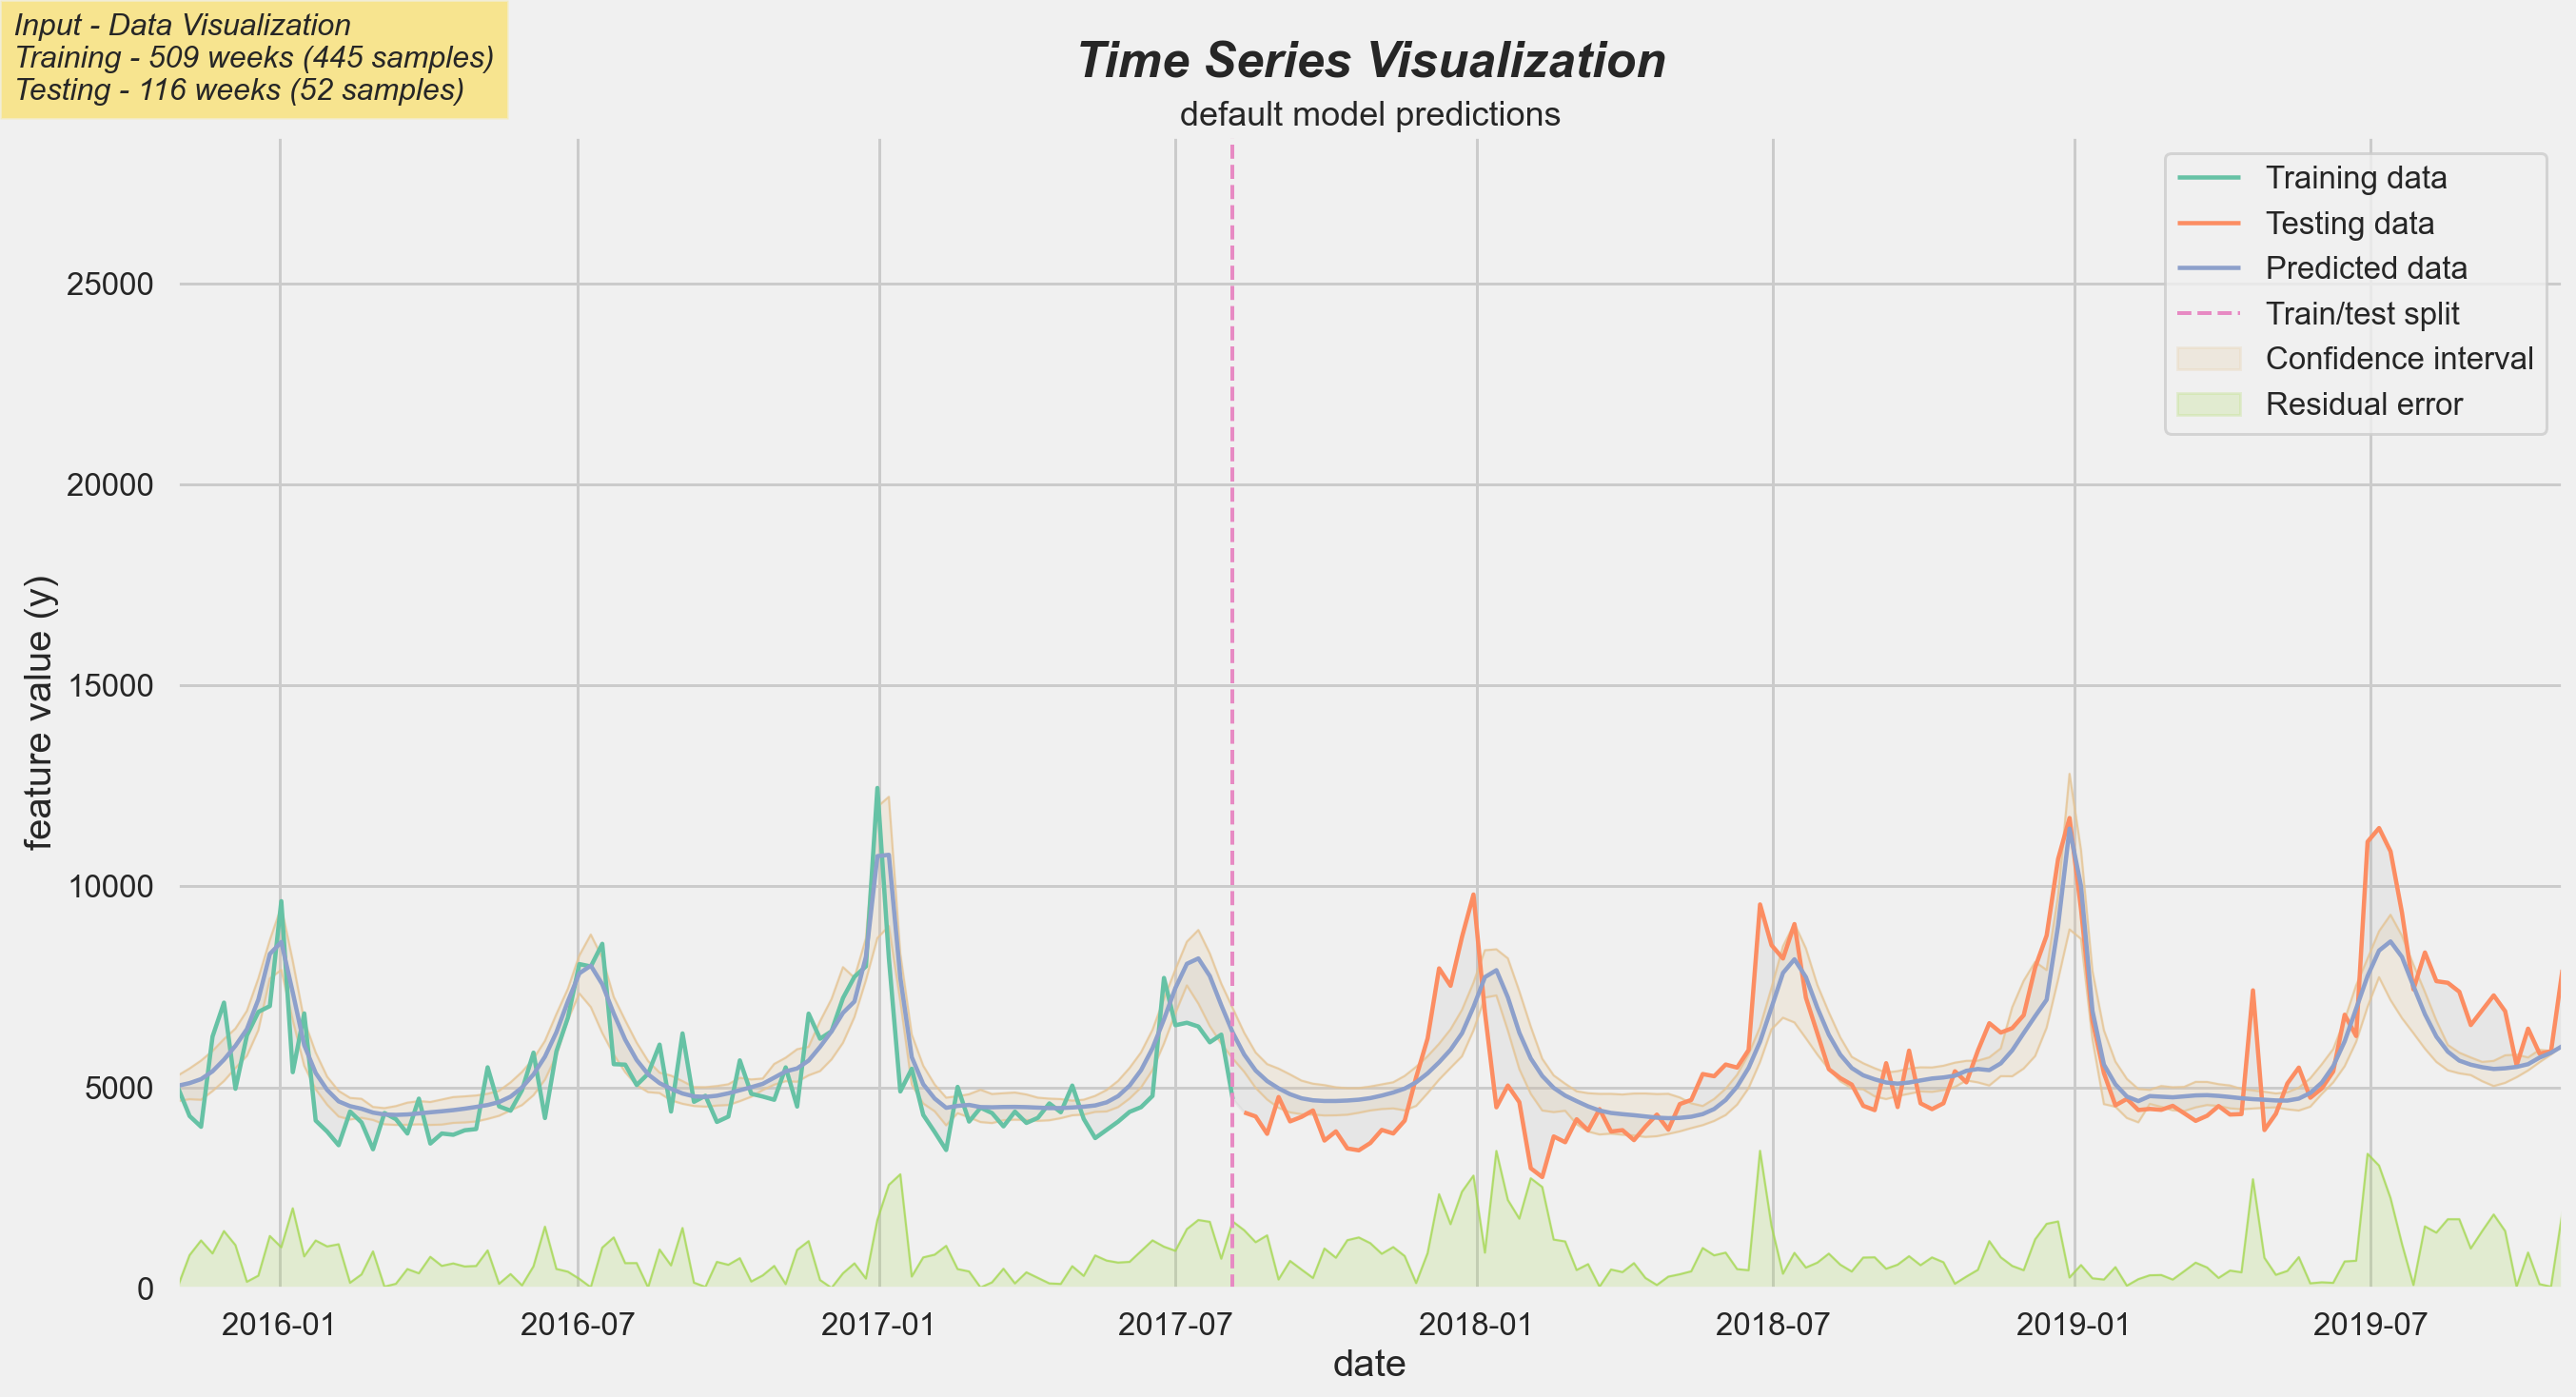

In [34]:
mwvh.plot_time_series(
    title='Time Series Visualization',
    subtitle='default model predictions',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    training=df_train,
    testing=df_test,
    confidence=pred['df'],
    confidence_label='Confidence interval',
    prediction=pred['df'],
    residual=pred['df'],
    residual_label='Residual error',
    ylabel='feature value (y)',
    split=threshold_date,
    window_size=get_n_weeks_window(16*params['output_size']))

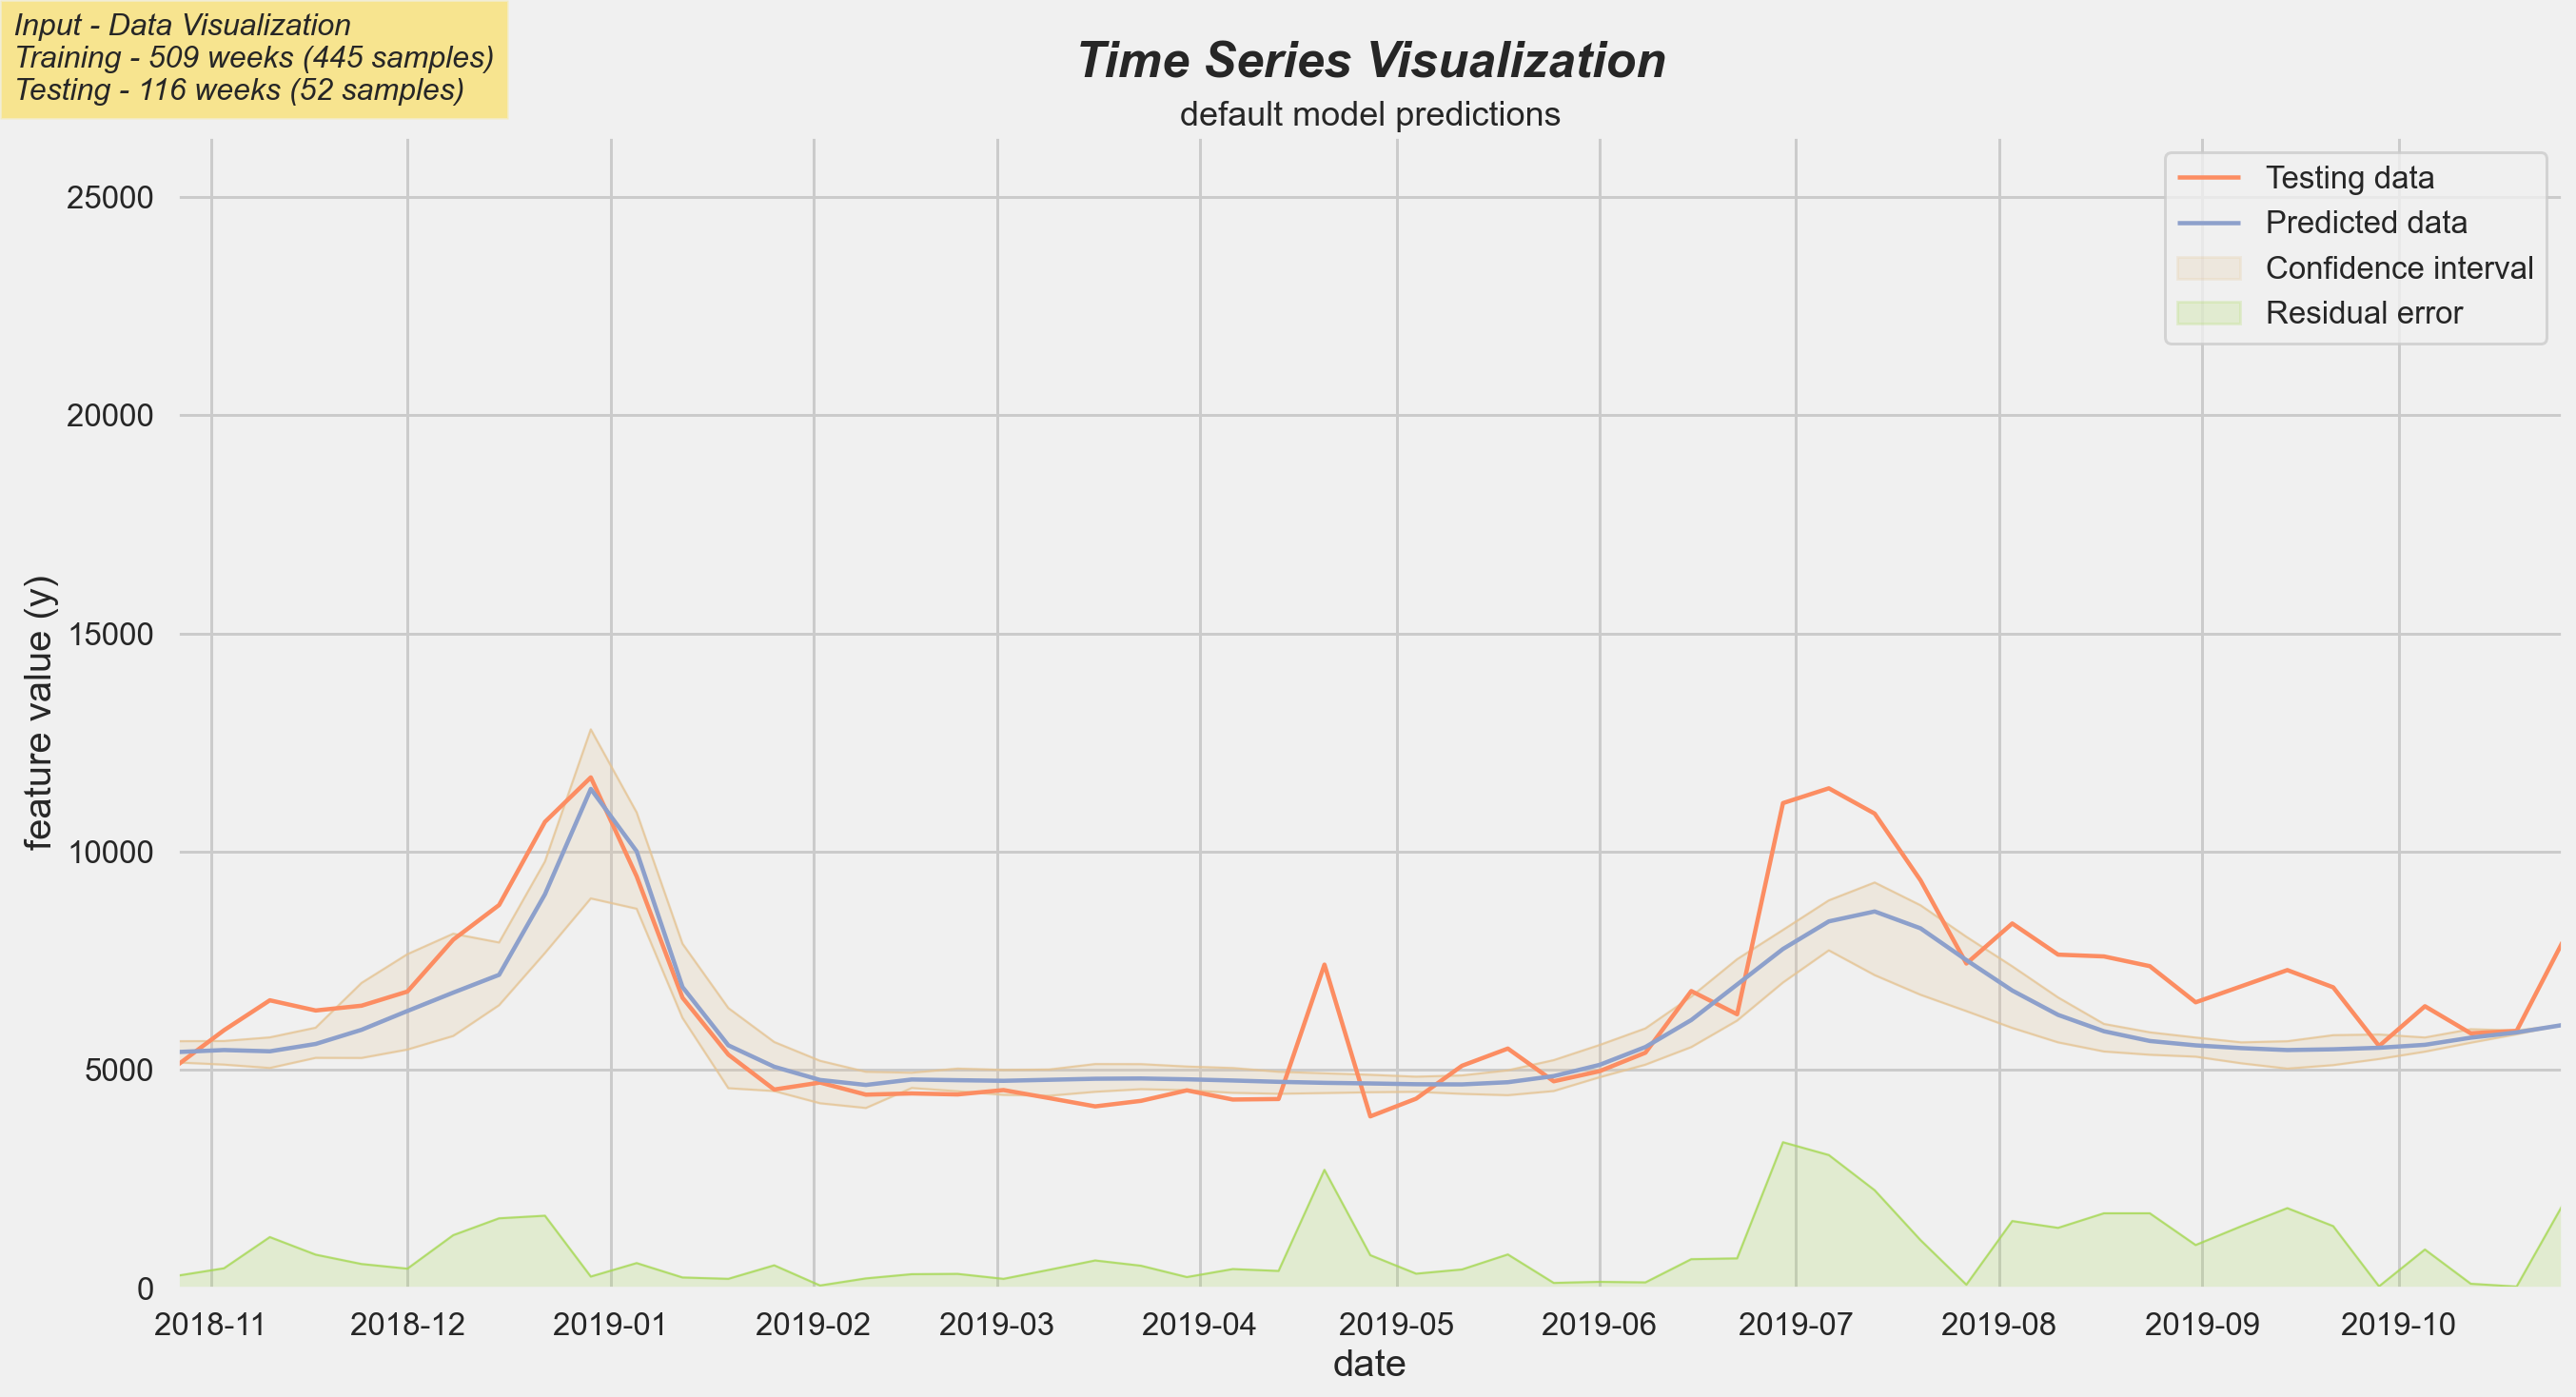

In [35]:
mwvh.plot_time_series(
    title='Time Series Visualization',
    subtitle='default model predictions',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    testing=df_test,
    confidence=pred['df'],
    confidence_label='Confidence interval',
    prediction=pred['df'],
    prediction_col='yhat',
    residual=pred['df'],
    residual_label='Residual error',
    ylabel='feature value (y)',
    window_size=get_n_weeks_window(4*params['output_size']))